# Retrieval
Query PostgreSQL for image embeddings that have been created and stored in the last two notebooks.

In [1]:
from PIL import Image
from transformers import AutoImageProcessor, AutoModel, AutoTokenizer
from datasets import load_dataset
import psycopg as pg
from pgvector.psycopg import register_vector
import numpy as np

In [6]:
connstr = "dbname=multimodal_rag user=pguser"

In [2]:
model_chkpoint = "openai/clip-vit-base-patch16"
model = AutoModel.from_pretrained(model_chkpoint)
processor = AutoImageProcessor.from_pretrained(model_chkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_chkpoint)

In [3]:
ds = load_dataset("jmhessel/newyorker_caption_contest", "explanation")
trainset = ds["train"]

In [4]:
txt_query = "professional dinosaurs in an office setting"
txt_query_toks = tokenizer([txt_query], truncation=True, return_tensors="pt")
txt_query_emb = model.get_text_features(**txt_query_toks)
txt_query_emb = txt_query_emb.detach().squeeze().numpy()
txt_query_emb.shape

(512,)

In [15]:
select_sql_1 = """
SELECT id, filename, description
FROM images
ORDER BY embedding <=> %s
LIMIT 1
"""

select_sql_2 = """
SELECT id, filename, embedding <=> %s as distance
FROM images
ORDER BY distance
LIMIT 3
"""

In [16]:
with pg.connect(connstr) as conn:
    register_vector(conn)
    with conn.cursor() as cur:
        cur.execute(select_sql_2, (txt_query_emb,))
        for row in cur:
            print(row)

(57, 'trainset[6].image', 0.6665835563167878)
(54, 'trainset[3].image', 0.7419420173376762)
(53, 'trainset[2].image', 0.7440221830636307)


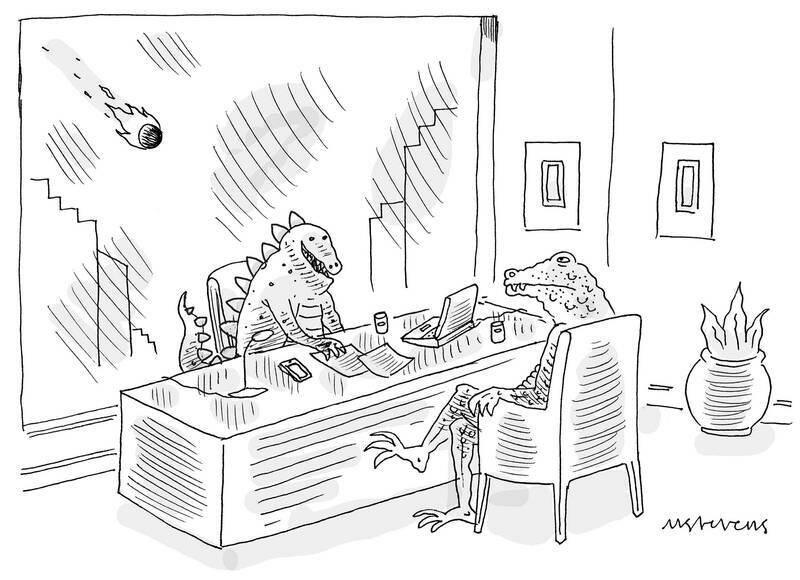

In [9]:
trainset[6]["image"]

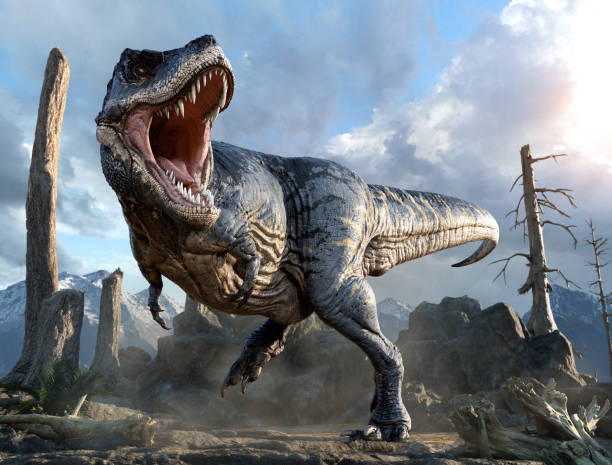

In [20]:
# Query image downloaded from-
# https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/beaver.png
img_query = Image.open("/tmp/learn/multimodal-rag/dinosaur.jpg")
img_query

In [21]:
img_query_tensor = processor(img_query, return_tensors="pt")
img_query_emb = model.get_image_features(**img_query_tensor)
img_query_emb = img_query_emb.detach().squeeze().numpy()
img_query_emb.shape

(512,)

In [22]:
with pg.connect(connstr) as conn:
    register_vector(conn)
    with conn.cursor() as cur:
        cur.execute(select_sql_2, (img_query_emb,))
        for row in cur:
            print(row)

(57, 'trainset[6].image', 0.3976118361583155)
(59, 'trainset[8].image', 0.4809048516418013)
(52, 'trainset[1].image', 0.5012634796397395)


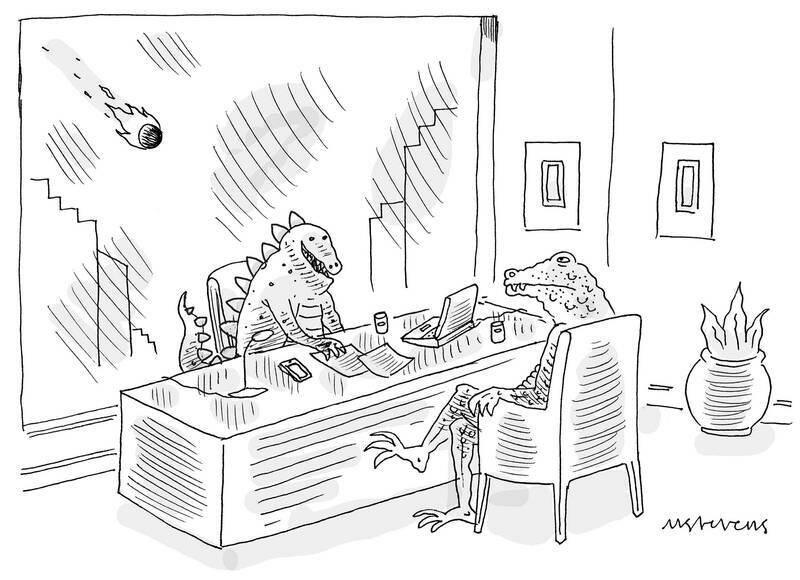

In [23]:
trainset[6]["image"]